<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: Calwebb_Image3, Resample step

<span style="color:red"> **Instruments Affected**</span>: FGS, MIRI, NIRCam, NIRISS, NIRSpec 

Tested on MIRI Simulated data

### Table of Contents
<div style="text-align: left"> 

<br>  [Introduction](#intro_ID) <br> [Run JWST Pipelines](#pipeline_ID) <br> [Imports](#imports_ID) <br> [Create an association table for your cal files and run them through calwebb_image3](#runpipeline_ID) <br> [Find Stars in Image and Determine their Coordinates](#runscript_ID) <br> [Compare RA and Dec to expected Values](#residual_ID) <br> [About This Notebook](#about_ID) <br>


</div>

<a id="intro_ID"></a>
# Introduction


This test is designed to test the resample step in the calwebb_image3 pipeline. At the end of the calwebb_image3 pipeline, the set of files defined in an association table will be distortion corrected and combined. Resample is the step that applies the distortion correction using the drizzling algorithm (as defined in the DrizzlePac handbook) and combines the listed files. For more information on the pipeline step visit the links below. 

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/resample/main.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/resample

The data for this test were created with the MIRI Data Simulator, and the documentation for that code can be found here: http://miri.ster.kuleuven.be/bin/view/Public/MIRISim_Public


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Image+Combination


### Defining Terms
Definition of terms or acronymns.

JWST: James Webb Space Telescope

MIRI: Mid-Infrared Instrument

MIRISim: MIRI Data Simulator

### Description of test

This test is performed by creating a set of simulated data with multiple point sources located at specified coordinates. The simulator puts in the expected distortion, so the initial output data comes out of the simulator in distorted coordinates. When this data is then run through calwebb_detector1, calwebb_image2 and calwebbb_image3, the combined, undistorted image should have the point sources registered at the expected locations. In flight, this test can be repeated with known stars that should be found at their expected coordinates.

### Create the data for testing

The set of data used in this particular test were created with the MIRI Data Simulator (MIRISim). Referring to the MIRISim link, you can see how to set up and run the simulator to re-create the input files if you wish. The data was run with a scene.ini file that specified what the scene should look like, with coordinates for the stars given in units of arcsecond offsets from the center of the field of view. The scene.ini file as well as the setup files simuation.ini and simulator.ini are needed to run the simulation.

Once in the mirisim conda environment, the simulation is run with the command line:
> mirisim simulation.ini

The simulator created four files, two exposures each at two different dither positions, using the specified filter. Make sure the WCSAXES header keyword in the SCI extension is set to 2 and not 4. If it is set to 4, change it to 2.



[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
## Run JWST Pipelines

The four files were then run individually through the calwebb_detector1 and calwebb_image2 pipelines. When running the calwebb_detector1 pipeline, increase the threshold for a detection in the jump step from 4 sigma to 10 sigma to avoid a current issue where the jump detection step flags a large percentage of pixels as jumps. This can be done on the command line. (commands to be typed start with $)

The pipelines can be run on the command line with the following commands or put into a script while using the pipeline conda environment.

$ strun calwebb_detector1.cfg filename --steps.jump.rejection_threshold 10.0

The output of the calwebb_detector1 pipeline is a set of four *rate.fits files which will then be run through the calwebb_image2 pipeline.

$ strun calwebb_image2.cfg filename

The output of the calwebb_image2 pipeline was then a set of four *cal.fits files. An association table was created that included these four files as input, and then the files and the association table were run through the calwebb_image3 pipeline. 

The cal files are stored in artifactory, and this notebook is meant to pull those files for the test of resample. Step through the cells of this notebook to run calwebb_image3 and then check the alignment.



[Top of Page](#title_ID)

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
data_dir = TemporaryDirectory()
os.chdir(data_dir.name)


<a id="imports_ID"></a>
# Imports
The following packages will need to be imported for the scripts to work.


* astropy.io for opening files
* astropy.stats for sigma clipping routine
* astropy.visualization for image plotting
* ci_watson.artifactory_helpers to read in data from artifactory
* jwst.datamodels for opening files as a JWST Datamodel
* jwst.pipeline to run the pipeline step/module
* jwst.associations to create association table
* numpy for calculations
* matplotlib.pyplot.plt to generate plot
* os for path information  
* photutils for star finding and aperture photometry
* regtest to retrieve data from artifactory needed to run notebook


[Top of Page](#title_ID)

In [2]:
from astropy.io import ascii, fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Column
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from ci_watson.artifactory_helpers import get_bigdata
from itertools import product
from jwst.datamodels import DrizProductModel, ImageModel
from jwst.pipeline import Image3Pipeline
from jwst import associations
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from jwst.associations import asn_from_list
import matplotlib.pyplot as plt
import numpy as np
import os
from photutils import CircularAperture, DAOStarFinder, CircularAnnulus, aperture_photometry
from jwst.regtest.regtestdata import RegtestData

<a id="runpipeline_ID"></a>
# Open an association table for your cal files and run them through calwebb_image3

Load the association table to use the .cal files that were output from calwebb_image2. That will be the input for calwebb_image3 that uses the resample step to combine each of the individual images.

[Top of Page](#title_ID)

In [3]:
# Use regtest infrastructure to access all input files associated with the association file

rtdata = RegtestData(inputs_root="jwst_validation_notebooks", env="validation_data")
rtdata.get_asn("resample/resample_miri_test/starfield_74_asnfile.json")
rtdata.input #this should be the list of files associated with the asn

'/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp21fydw5g/starfield_74_asnfile.json'

In [4]:
# Run Calwebb_image3 on the association table
    
# set any specific parameters
# tweakreg parameters to allow data to run
fwhm=2.5  # Gaussian kernel FWHM of objects expected, default=2.5
minobj=5  # minimum number of objects needed to match positions for a good fit, default=15
snr= 250 # signal to noise threshold, default=5
sigma= 3 # clipping limit, in sigma units, used when performing fit, default=3
fit_geom='shift' # ftype of affine transformation to be considered when fitting catalogs, default='general'
use2dhist=False  # boolean indicating whether to use 2D histogram to find initial offset, default=True
   
pipe3=Image3Pipeline()    
pipe3.tweakreg.kernel_fwhm = fwhm
pipe3.tweakreg.snr_threshold = snr
pipe3.tweakreg.minobj = minobj
pipe3.tweakreg.sigma = sigma
pipe3.tweakreg.fitgeometry = fit_geom
pipe3.tweakreg.use2dhist = use2dhist
#pipe3.skymatch.skip = True        # test to see if this affects the final output
pipe3.source_catalog.save_results = True
pipe3.save_results = True

# run Image3

im = pipe3.run(rtdata.input)

2021-02-18 20:12:21,892 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2021-02-18 20:12:21,894 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2021-02-18 20:12:21,895 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2021-02-18 20:12:21,896 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2021-02-18 20:12:21,898 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2021-02-18 20:12:21,899 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2021-02-18 20:12:21,900 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2021-02-18 20:12:22,012 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp21fydw5g/starfield_74_asnfile.json',).


2021-02-18 20:12:22,017 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'tweakreg': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 250, 'brightest':

2021-02-18 20:12:22,377 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIMAGE_F1130Wexp1_74test_cal.fits' reftypes = ['abvegaoffset', 'apcorr', 'drizpars']


2021-02-18 20:12:22,458 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_system_datalvl_0002.rmap       694 bytes  (1 / 141 files) (0 / 390.2 K bytes)


2021-02-18 20:12:22,490 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_system_calver_0024.rmap      2.8 K bytes  (2 / 141 files) (694 / 390.2 K bytes)


2021-02-18 20:12:22,522 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_system_0023.imap               385 bytes  (3 / 141 files) (3.4 K / 390.2 K bytes)


2021-02-18 20:12:22,552 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_wavelengthrange_0017.rmap    1.1 K bytes  (4 / 141 files) (3.8 K / 390.2 K bytes)


2021-02-18 20:12:22,583 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_wavecorr_0003.rmap      833 bytes  (5 / 141 files) (4.9 K / 390.2 K bytes)


2021-02-18 20:12:22,612 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_superbias_0039.rmap   15.9 K bytes  (6 / 141 files) (5.8 K / 390.2 K bytes)


2021-02-18 20:12:22,641 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_sflat_0011.rmap     19.3 K bytes  (7 / 141 files) (21.7 K / 390.2 K bytes)


2021-02-18 20:12:22,672 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_saturation_0017.rmap    2.0 K bytes  (8 / 141 files) (40.9 K / 390.2 K bytes)


2021-02-18 20:12:22,703 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_refpix_0014.rmap     1.5 K bytes  (9 / 141 files) (42.9 K / 390.2 K bytes)


2021-02-18 20:12:22,733 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_readnoise_0020.rmap    2.3 K bytes  (10 / 141 files) (44.5 K / 390.2 K bytes)


2021-02-18 20:12:22,763 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_photom_0012.rmap       907 bytes  (11 / 141 files) (46.8 K / 390.2 K bytes)


2021-02-18 20:12:22,792 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_pathloss_0003.rmap      932 bytes  (12 / 141 files) (47.7 K / 390.2 K bytes)


2021-02-18 20:12:22,825 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_pars-spec2pipeline_0004.rmap    1.8 K bytes  (13 / 141 files) (48.6 K / 390.2 K bytes)


2021-02-18 20:12:22,852 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_ote_0020.rmap        1.0 K bytes  (14 / 141 files) (50.5 K / 390.2 K bytes)


2021-02-18 20:12:22,883 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_msaoper_0003.rmap      783 bytes  (15 / 141 files) (51.5 K / 390.2 K bytes)


2021-02-18 20:12:22,913 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_msa_0018.rmap        1.0 K bytes  (16 / 141 files) (52.3 K / 390.2 K bytes)


2021-02-18 20:12:22,939 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_mask_0021.rmap       1.5 K bytes  (17 / 141 files) (53.3 K / 390.2 K bytes)


2021-02-18 20:12:22,966 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_linearity_0017.rmap    1.6 K bytes  (18 / 141 files) (54.7 K / 390.2 K bytes)


2021-02-18 20:12:22,998 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_ipc_0006.rmap          876 bytes  (19 / 141 files) (56.3 K / 390.2 K bytes)


2021-02-18 20:12:23,030 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_ifuslicer_0008.rmap    1.0 K bytes  (20 / 141 files) (57.2 K / 390.2 K bytes)


2021-02-18 20:12:23,060 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_ifupost_0010.rmap      991 bytes  (21 / 141 files) (58.2 K / 390.2 K bytes)


2021-02-18 20:12:23,090 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_ifufore_0008.rmap      991 bytes  (22 / 141 files) (59.2 K / 390.2 K bytes)


2021-02-18 20:12:23,123 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_gain_0019.rmap       1.8 K bytes  (23 / 141 files) (60.2 K / 390.2 K bytes)


2021-02-18 20:12:23,153 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_fpa_0019.rmap        1.0 K bytes  (24 / 141 files) (61.9 K / 390.2 K bytes)


2021-02-18 20:12:23,182 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_fore_0017.rmap       3.4 K bytes  (25 / 141 files) (63.0 K / 390.2 K bytes)


2021-02-18 20:12:23,209 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_flat_0014.rmap       3.8 K bytes  (26 / 141 files) (66.4 K / 390.2 K bytes)


2021-02-18 20:12:23,237 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_fflat_0009.rmap      3.3 K bytes  (27 / 141 files) (70.2 K / 390.2 K bytes)


2021-02-18 20:12:23,268 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_extract1d_0012.rmap    1.2 K bytes  (28 / 141 files) (73.5 K / 390.2 K bytes)


2021-02-18 20:12:23,299 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_disperser_0019.rmap    3.9 K bytes  (29 / 141 files) (74.7 K / 390.2 K bytes)


2021-02-18 20:12:23,329 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_dflat_0006.rmap      1.1 K bytes  (30 / 141 files) (78.7 K / 390.2 K bytes)


2021-02-18 20:12:23,357 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_dark_0032.rmap      14.5 K bytes  (31 / 141 files) (79.7 K / 390.2 K bytes)


2021-02-18 20:12:23,388 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_cubepar_0007.rmap      915 bytes  (32 / 141 files) (94.3 K / 390.2 K bytes)


2021-02-18 20:12:23,420 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_collimator_0017.rmap    1.1 K bytes  (33 / 141 files) (95.2 K / 390.2 K bytes)


2021-02-18 20:12:23,449 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_camera_0017.rmap     1.0 K bytes  (34 / 141 files) (96.2 K / 390.2 K bytes)


2021-02-18 20:12:23,481 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_barshadow_0003.rmap      877 bytes  (35 / 141 files) (97.3 K / 390.2 K bytes)


2021-02-18 20:12:23,510 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_area_0014.rmap       4.5 K bytes  (36 / 141 files) (98.1 K / 390.2 K bytes)


2021-02-18 20:12:23,540 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_apcorr_0005.rmap     5.3 K bytes  (37 / 141 files) (102.6 K / 390.2 K bytes)


2021-02-18 20:12:23,570 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_0217.imap            4.8 K bytes  (38 / 141 files) (107.9 K / 390.2 K bytes)


2021-02-18 20:12:23,599 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_wfssbkg_0002.rmap     2.3 K bytes  (39 / 141 files) (112.7 K / 390.2 K bytes)


2021-02-18 20:12:23,629 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_wavelengthrange_0005.rmap      811 bytes  (40 / 141 files) (115.0 K / 390.2 K bytes)


2021-02-18 20:12:23,657 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_trappars_0004.rmap      753 bytes  (41 / 141 files) (115.8 K / 390.2 K bytes)


2021-02-18 20:12:23,686 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_trapdensity_0004.rmap      774 bytes  (42 / 141 files) (116.5 K / 390.2 K bytes)


2021-02-18 20:12:23,716 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_throughput_0004.rmap      979 bytes  (43 / 141 files) (117.3 K / 390.2 K bytes)


2021-02-18 20:12:23,745 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_superbias_0022.rmap    4.6 K bytes  (44 / 141 files) (118.3 K / 390.2 K bytes)


2021-02-18 20:12:23,774 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_specwcs_0005.rmap     2.3 K bytes  (45 / 141 files) (122.9 K / 390.2 K bytes)


2021-02-18 20:12:23,804 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_saturation_0011.rmap      693 bytes  (46 / 141 files) (125.2 K / 390.2 K bytes)


2021-02-18 20:12:23,834 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_readnoise_0008.rmap      969 bytes  (47 / 141 files) (125.9 K / 390.2 K bytes)


2021-02-18 20:12:23,864 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_photom_0026.rmap        996 bytes  (48 / 141 files) (126.8 K / 390.2 K bytes)


2021-02-18 20:12:23,895 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_persat_0005.rmap        738 bytes  (49 / 141 files) (127.8 K / 390.2 K bytes)


2021-02-18 20:12:23,924 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_pathloss_0002.rmap      707 bytes  (50 / 141 files) (128.6 K / 390.2 K bytes)


2021-02-18 20:12:23,955 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_pars-tweakregstep_0003.rmap    2.2 K bytes  (51 / 141 files) (129.3 K / 390.2 K bytes)


2021-02-18 20:12:23,986 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_pars-image2pipeline_0002.rmap      712 bytes  (52 / 141 files) (131.5 K / 390.2 K bytes)


2021-02-18 20:12:24,020 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_mask_0017.rmap          735 bytes  (53 / 141 files) (132.2 K / 390.2 K bytes)


2021-02-18 20:12:24,045 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_linearity_0016.rmap      827 bytes  (54 / 141 files) (133.0 K / 390.2 K bytes)


2021-02-18 20:12:24,076 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_ipc_0006.rmap           590 bytes  (55 / 141 files) (133.8 K / 390.2 K bytes)


2021-02-18 20:12:24,107 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_gain_0010.rmap          838 bytes  (56 / 141 files) (134.4 K / 390.2 K bytes)


2021-02-18 20:12:24,140 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_flat_0019.rmap        4.1 K bytes  (57 / 141 files) (135.2 K / 390.2 K bytes)


2021-02-18 20:12:24,170 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_extract1d_0006.rmap      854 bytes  (58 / 141 files) (139.4 K / 390.2 K bytes)


2021-02-18 20:12:24,201 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_drizpars_0004.rmap      519 bytes  (59 / 141 files) (140.2 K / 390.2 K bytes)


2021-02-18 20:12:24,232 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_distortion_0017.rmap      899 bytes  (60 / 141 files) (140.7 K / 390.2 K bytes)


2021-02-18 20:12:24,261 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_dark_0027.rmap        4.0 K bytes  (61 / 141 files) (141.6 K / 390.2 K bytes)


2021-02-18 20:12:24,290 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_area_0012.rmap        1.1 K bytes  (62 / 141 files) (145.6 K / 390.2 K bytes)


2021-02-18 20:12:24,319 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_apcorr_0004.rmap      4.1 K bytes  (63 / 141 files) (146.7 K / 390.2 K bytes)


2021-02-18 20:12:24,349 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_abvegaoffset_0002.rmap    1.3 K bytes  (64 / 141 files) (150.8 K / 390.2 K bytes)


2021-02-18 20:12:24,381 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_0139.imap             4.6 K bytes  (65 / 141 files) (152.1 K / 390.2 K bytes)


2021-02-18 20:12:24,411 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_wfssbkg_0003.rmap     7.2 K bytes  (66 / 141 files) (156.7 K / 390.2 K bytes)


2021-02-18 20:12:24,448 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_wavelengthrange_0009.rmap      945 bytes  (67 / 141 files) (163.9 K / 390.2 K bytes)


2021-02-18 20:12:24,478 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_tsophot_0002.rmap       794 bytes  (68 / 141 files) (164.8 K / 390.2 K bytes)


2021-02-18 20:12:24,508 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_trappars_0003.rmap    1.6 K bytes  (69 / 141 files) (165.6 K / 390.2 K bytes)


2021-02-18 20:12:24,538 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_trapdensity_0003.rmap    1.6 K bytes  (70 / 141 files) (167.2 K / 390.2 K bytes)


2021-02-18 20:12:24,568 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_superbias_0006.rmap    2.6 K bytes  (71 / 141 files) (168.8 K / 390.2 K bytes)


2021-02-18 20:12:24,597 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_specwcs_0008.rmap     1.7 K bytes  (72 / 141 files) (171.4 K / 390.2 K bytes)


2021-02-18 20:12:24,629 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_saturation_0006.rmap    2.2 K bytes  (73 / 141 files) (173.1 K / 390.2 K bytes)


2021-02-18 20:12:24,656 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_readnoise_0006.rmap    5.6 K bytes  (74 / 141 files) (175.2 K / 390.2 K bytes)


2021-02-18 20:12:24,679 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_psfmask_0005.rmap    10.7 K bytes  (75 / 141 files) (180.8 K / 390.2 K bytes)


2021-02-18 20:12:24,706 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_photom_0010.rmap      4.3 K bytes  (76 / 141 files) (191.6 K / 390.2 K bytes)


2021-02-18 20:12:24,733 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_persat_0004.rmap      1.6 K bytes  (77 / 141 files) (195.9 K / 390.2 K bytes)


2021-02-18 20:12:24,760 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_pars-tweakregstep_0002.rmap    4.5 K bytes  (78 / 141 files) (197.5 K / 390.2 K bytes)


2021-02-18 20:12:24,786 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_mask_0007.rmap        2.3 K bytes  (79 / 141 files) (201.9 K / 390.2 K bytes)


2021-02-18 20:12:24,811 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_linearity_0011.rmap    2.4 K bytes  (80 / 141 files) (204.2 K / 390.2 K bytes)


2021-02-18 20:12:24,840 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_ipc_0003.rmap         2.0 K bytes  (81 / 141 files) (206.6 K / 390.2 K bytes)


2021-02-18 20:12:24,869 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_gain_0010.rmap        2.3 K bytes  (82 / 141 files) (208.6 K / 390.2 K bytes)


2021-02-18 20:12:24,900 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_flat_0016.rmap       28.9 K bytes  (83 / 141 files) (210.9 K / 390.2 K bytes)


2021-02-18 20:12:24,930 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_filteroffset_0003.rmap    1.1 K bytes  (84 / 141 files) (239.7 K / 390.2 K bytes)


2021-02-18 20:12:24,959 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_drizpars_0001.rmap      519 bytes  (85 / 141 files) (240.9 K / 390.2 K bytes)


2021-02-18 20:12:24,988 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_distortion_0022.rmap    9.1 K bytes  (86 / 141 files) (241.4 K / 390.2 K bytes)


2021-02-18 20:12:25,016 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_dark_0021.rmap       14.2 K bytes  (87 / 141 files) (250.5 K / 390.2 K bytes)


2021-02-18 20:12:25,041 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_area_0006.rmap        4.6 K bytes  (88 / 141 files) (264.7 K / 390.2 K bytes)


2021-02-18 20:12:25,063 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_apcorr_0007.rmap      4.2 K bytes  (89 / 141 files) (269.3 K / 390.2 K bytes)


2021-02-18 20:12:25,089 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_abvegaoffset_0002.rmap    1.3 K bytes  (90 / 141 files) (273.5 K / 390.2 K bytes)


2021-02-18 20:12:25,118 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_0149.imap             4.5 K bytes  (91 / 141 files) (274.8 K / 390.2 K bytes)


2021-02-18 20:12:25,148 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_wcsregions_0009.rmap    1.1 K bytes  (92 / 141 files) (279.3 K / 390.2 K bytes)


2021-02-18 20:12:25,178 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_wavelengthrange_0020.rmap    1.1 K bytes  (93 / 141 files) (280.4 K / 390.2 K bytes)


2021-02-18 20:12:25,207 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_tsophot_0002.rmap         780 bytes  (94 / 141 files) (281.5 K / 390.2 K bytes)


2021-02-18 20:12:25,237 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_straymask_0007.rmap       885 bytes  (95 / 141 files) (282.3 K / 390.2 K bytes)


2021-02-18 20:12:25,268 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_specwcs_0026.rmap       4.0 K bytes  (96 / 141 files) (283.2 K / 390.2 K bytes)


2021-02-18 20:12:25,299 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_saturation_0012.rmap      961 bytes  (97 / 141 files) (287.1 K / 390.2 K bytes)


2021-02-18 20:12:25,328 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_rscd_0006.rmap            860 bytes  (98 / 141 files) (288.1 K / 390.2 K bytes)


2021-02-18 20:12:25,359 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_resol_0004.rmap           739 bytes  (99 / 141 files) (289.0 K / 390.2 K bytes)


2021-02-18 20:12:25,390 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_reset_0012.rmap         2.2 K bytes  (100 / 141 files) (289.7 K / 390.2 K bytes)


2021-02-18 20:12:25,420 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_regions_0026.rmap       3.6 K bytes  (101 / 141 files) (291.9 K / 390.2 K bytes)


2021-02-18 20:12:25,450 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_readnoise_0015.rmap     3.3 K bytes  (102 / 141 files) (295.5 K / 390.2 K bytes)


2021-02-18 20:12:25,480 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_psfmask_0003.rmap       1.3 K bytes  (103 / 141 files) (298.8 K / 390.2 K bytes)


2021-02-18 20:12:25,509 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_photom_0030.rmap        5.5 K bytes  (104 / 141 files) (300.0 K / 390.2 K bytes)


2021-02-18 20:12:25,539 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_pars-tweakregstep_0002.rmap    1.8 K bytes  (105 / 141 files) (305.5 K / 390.2 K bytes)


2021-02-18 20:12:25,568 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_mask_0015.rmap            893 bytes  (106 / 141 files) (307.4 K / 390.2 K bytes)


2021-02-18 20:12:25,598 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_linearity_0013.rmap     1.9 K bytes  (107 / 141 files) (308.3 K / 390.2 K bytes)


2021-02-18 20:12:25,627 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_ipc_0005.rmap             721 bytes  (108 / 141 files) (310.2 K / 390.2 K bytes)


2021-02-18 20:12:25,657 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_gain_0007.rmap            893 bytes  (109 / 141 files) (310.9 K / 390.2 K bytes)


2021-02-18 20:12:25,687 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_fringe_0015.rmap        3.5 K bytes  (110 / 141 files) (311.8 K / 390.2 K bytes)


2021-02-18 20:12:25,716 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_flat_0048.rmap         21.9 K bytes  (111 / 141 files) (315.3 K / 390.2 K bytes)


2021-02-18 20:12:25,746 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_filteroffset_0020.rmap    1.1 K bytes  (112 / 141 files) (337.3 K / 390.2 K bytes)


2021-02-18 20:12:25,776 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_extract1d_0013.rmap     1.1 K bytes  (113 / 141 files) (338.4 K / 390.2 K bytes)


2021-02-18 20:12:25,807 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_drizpars_0002.rmap        511 bytes  (114 / 141 files) (339.5 K / 390.2 K bytes)


2021-02-18 20:12:25,838 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_distortion_0032.rmap    3.6 K bytes  (115 / 141 files) (340.0 K / 390.2 K bytes)


2021-02-18 20:12:25,867 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_dark_0021.rmap          3.2 K bytes  (116 / 141 files) (343.5 K / 390.2 K bytes)


2021-02-18 20:12:25,898 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_cubepar_0008.rmap         686 bytes  (117 / 141 files) (346.7 K / 390.2 K bytes)


2021-02-18 20:12:25,926 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_area_0011.rmap            755 bytes  (118 / 141 files) (347.4 K / 390.2 K bytes)


2021-02-18 20:12:25,955 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_apcorr_0007.rmap        4.3 K bytes  (119 / 141 files) (348.2 K / 390.2 K bytes)


2021-02-18 20:12:25,985 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_abvegaoffset_0002.rmap    1.3 K bytes  (120 / 141 files) (352.5 K / 390.2 K bytes)


2021-02-18 20:12:26,016 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_0219.imap               4.6 K bytes  (121 / 141 files) (353.7 K / 390.2 K bytes)


2021-02-18 20:12:26,043 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_trappars_0004.rmap         903 bytes  (122 / 141 files) (358.3 K / 390.2 K bytes)


2021-02-18 20:12:26,069 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_trapdensity_0004.rmap      930 bytes  (123 / 141 files) (359.2 K / 390.2 K bytes)


2021-02-18 20:12:26,095 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_superbias_0015.rmap      3.8 K bytes  (124 / 141 files) (360.1 K / 390.2 K bytes)


2021-02-18 20:12:26,128 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_saturation_0009.rmap       779 bytes  (125 / 141 files) (363.9 K / 390.2 K bytes)


2021-02-18 20:12:26,157 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_readnoise_0011.rmap      1.3 K bytes  (126 / 141 files) (364.7 K / 390.2 K bytes)


2021-02-18 20:12:26,187 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_photom_0013.rmap         1.1 K bytes  (127 / 141 files) (366.0 K / 390.2 K bytes)


2021-02-18 20:12:26,217 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_persat_0004.rmap           884 bytes  (128 / 141 files) (367.1 K / 390.2 K bytes)


2021-02-18 20:12:26,247 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_pars-tweakregstep_0002.rmap      850 bytes  (129 / 141 files) (368.0 K / 390.2 K bytes)


2021-02-18 20:12:26,277 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_mask_0018.rmap           1.2 K bytes  (130 / 141 files) (368.8 K / 390.2 K bytes)


2021-02-18 20:12:26,309 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_linearity_0013.rmap        925 bytes  (131 / 141 files) (370.0 K / 390.2 K bytes)


2021-02-18 20:12:26,338 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_ipc_0003.rmap              614 bytes  (132 / 141 files) (370.9 K / 390.2 K bytes)


2021-02-18 20:12:26,368 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_gain_0010.rmap             890 bytes  (133 / 141 files) (371.5 K / 390.2 K bytes)


2021-02-18 20:12:26,398 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_flat_0009.rmap           1.1 K bytes  (134 / 141 files) (372.4 K / 390.2 K bytes)


2021-02-18 20:12:26,427 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_distortion_0007.rmap     1.1 K bytes  (135 / 141 files) (373.5 K / 390.2 K bytes)


2021-02-18 20:12:26,457 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_dark_0013.rmap           4.3 K bytes  (136 / 141 files) (374.6 K / 390.2 K bytes)


2021-02-18 20:12:26,490 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_area_0009.rmap           1.0 K bytes  (137 / 141 files) (378.9 K / 390.2 K bytes)


2021-02-18 20:12:26,523 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_apcorr_0002.rmap         4.1 K bytes  (138 / 141 files) (380.0 K / 390.2 K bytes)


2021-02-18 20:12:26,556 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_abvegaoffset_0002.rmap    1.3 K bytes  (139 / 141 files) (384.1 K / 390.2 K bytes)


2021-02-18 20:12:26,586 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_0088.imap                4.3 K bytes  (140 / 141 files) (385.3 K / 390.2 K bytes)


2021-02-18 20:12:26,616 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_0676.pmap                      580 bytes  (141 / 141 files) (389.6 K / 390.2 K bytes)


2021-02-18 20:12:26,866 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_abvegaoffset_0001.asdf    1.7 K bytes  (1 / 3 files) (0 / 33.3 K bytes)


2021-02-18 20:12:26,899 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_apcorr_0005.fits   23.0 K bytes  (2 / 3 files) (1.7 K / 33.3 K bytes)


2021-02-18 20:12:26,928 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits    8.6 K bytes  (3 / 3 files) (24.7 K / 33.3 K bytes)


2021-02-18 20:12:26,958 - stpipe.Image3Pipeline - INFO - Prefetch for ABVEGAOFFSET reference file is 'crds_cache/references/jwst/miri/jwst_miri_abvegaoffset_0001.asdf'.


2021-02-18 20:12:26,958 - stpipe.Image3Pipeline - INFO - Prefetch for APCORR reference file is 'crds_cache/references/jwst/miri/jwst_miri_apcorr_0005.fits'.


2021-02-18 20:12:26,959 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is 'crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'.


2021-02-18 20:12:26,960 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2021-02-18 20:12:27,549 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<ModelContainer>,).


2021-02-18 20:12:27,551 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp21fydw5g', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 250, 'brightest': 1000, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 5, 'searchrad': 1.0, 'use2dhist': False, 'separation': 0.5, 'tolerance': 1.0, 'xoffset': 0.0, 'yoffset': 0.0, 'fitgeometry': 'shift', 'nclip': 3, 'sigma': 3, 'align_to_gaia': False, 'gaia_catalog': 'GAIADR2', 'min_gaia': 5, 'save_gaia_catalog': False}


2021-02-18 20:12:27,809 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 50 sources in det_image_seq1_MIRIMAGE_F1130Wexp1_74test_cal.fits.


2021-02-18 20:12:28,046 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 50 sources in det_image_seq1_MIRIMAGE_F1130Wexp2_74test_cal.fits.


2021-02-18 20:12:28,283 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 49 sources in det_image_seq2_MIRIMAGE_F1130Wexp1_74test_cal.fits.


2021-02-18 20:12:28,526 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 50 sources in det_image_seq2_MIRIMAGE_F1130Wexp2_74test_cal.fits.


2021-02-18 20:12:28,530 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-02-18 20:12:28,531 - stpipe.Image3Pipeline.tweakreg - INFO - Number of image groups to be aligned: 4.


2021-02-18 20:12:28,531 - stpipe.Image3Pipeline.tweakreg - INFO - Image groups:


2021-02-18 20:12:28,554 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'det_image_seq1_MIRIMAGE_F1130Wexp1_74test_cal':


2021-02-18 20:12:28,554 - stpipe.Image3Pipeline.tweakreg - INFO -      det_image_seq1_MIRIMAGE_F1130Wexp1_74test_cal


2021-02-18 20:12:28,576 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'det_image_seq1_MIRIMAGE_F1130Wexp2_74test_cal':


2021-02-18 20:12:28,576 - stpipe.Image3Pipeline.tweakreg - INFO -      det_image_seq1_MIRIMAGE_F1130Wexp2_74test_cal


2021-02-18 20:12:28,597 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'det_image_seq2_MIRIMAGE_F1130Wexp1_74test_cal':


2021-02-18 20:12:28,598 - stpipe.Image3Pipeline.tweakreg - INFO -      det_image_seq2_MIRIMAGE_F1130Wexp1_74test_cal


2021-02-18 20:12:28,619 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'det_image_seq2_MIRIMAGE_F1130Wexp2_74test_cal':


2021-02-18 20:12:28,619 - stpipe.Image3Pipeline.tweakreg - INFO -      det_image_seq2_MIRIMAGE_F1130Wexp2_74test_cal


2021-02-18 20:12:28,620 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-02-18 20:12:28,620 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-02-18 20:12:28,620 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() started on 2021-02-18 20:12:28.620302


2021-02-18 20:12:28,620 - stpipe.Image3Pipeline.tweakreg - INFO -       Version 0.7.1


2021-02-18 20:12:28,621 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-02-18 20:12:28,694 - stpipe.Image3Pipeline.tweakreg - INFO - Selected image 'GROUP ID: det_image_seq1_MIRIMAGE_F1130Wexp1_74test_cal' as reference image


2021-02-18 20:12:28,698 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: det_image_seq1_MIRIMAGE_F1130Wexp2_74test_cal' to the reference catalog.


2021-02-18 20:12:28,778 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'det_image_seq1_MIRIMAGE_F1130Wexp2_74test_cal' catalog with sources from the reference 'det_image_seq1_MIRIMAGE_F1130Wexp1_74test_cal' catalog.


2021-02-18 20:12:28,779 - stpipe.Image3Pipeline.tweakreg - INFO - Found 49 matches for 'GROUP ID: det_image_seq1_MIRIMAGE_F1130Wexp2_74test_cal'...


2021-02-18 20:12:28,780 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-02-18 20:12:28,781 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: det_image_seq1_MIRIMAGE_F1130Wexp2_74test_cal:


2021-02-18 20:12:28,782 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -6.58944e-07  YSH: -1.44021e-05


2021-02-18 20:12:28,782 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-02-18 20:12:28,782 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.000302863   FIT MAE: 0.000262083


2021-02-18 20:12:28,782 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 49 objects.


2021-02-18 20:12:28,816 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: det_image_seq2_MIRIMAGE_F1130Wexp1_74test_cal' to the reference catalog.


2021-02-18 20:12:28,900 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'det_image_seq2_MIRIMAGE_F1130Wexp1_74test_cal' catalog with sources from the reference 'det_image_seq1_MIRIMAGE_F1130Wexp1_74test_cal' catalog.


2021-02-18 20:12:28,901 - stpipe.Image3Pipeline.tweakreg - INFO - Found 49 matches for 'GROUP ID: det_image_seq2_MIRIMAGE_F1130Wexp1_74test_cal'...


2021-02-18 20:12:28,902 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-02-18 20:12:28,904 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: det_image_seq2_MIRIMAGE_F1130Wexp1_74test_cal:


2021-02-18 20:12:28,904 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000511129  YSH: 0.000423463


2021-02-18 20:12:28,904 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-02-18 20:12:28,904 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.0033229   FIT MAE: 0.00257355


2021-02-18 20:12:28,905 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 48 objects.


2021-02-18 20:12:28,937 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: det_image_seq2_MIRIMAGE_F1130Wexp2_74test_cal' to the reference catalog.


2021-02-18 20:12:29,023 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'det_image_seq2_MIRIMAGE_F1130Wexp2_74test_cal' catalog with sources from the reference 'det_image_seq1_MIRIMAGE_F1130Wexp1_74test_cal' catalog.


2021-02-18 20:12:29,024 - stpipe.Image3Pipeline.tweakreg - INFO - Found 49 matches for 'GROUP ID: det_image_seq2_MIRIMAGE_F1130Wexp2_74test_cal'...


2021-02-18 20:12:29,024 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-02-18 20:12:29,026 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: det_image_seq2_MIRIMAGE_F1130Wexp2_74test_cal:


2021-02-18 20:12:29,026 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000665744  YSH: 0.000422398


2021-02-18 20:12:29,027 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-02-18 20:12:29,027 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00331562   FIT MAE: 0.00258955


2021-02-18 20:12:29,027 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 48 objects.


2021-02-18 20:12:29,060 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-02-18 20:12:29,060 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() ended on 2021-02-18 20:12:29.060050


2021-02-18 20:12:29,060 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() TOTAL RUN TIME: 0:00:00.439748


2021-02-18 20:12:29,061 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-02-18 20:12:29,129 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg done


2021-02-18 20:12:29,301 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).


2021-02-18 20:12:29,302 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp21fydw5g', 'skymethod': 'global+match', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '0', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}


2021-02-18 20:12:29,328 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-02-18 20:12:29,328 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() started on 2021-02-18 20:12:29.328306


2021-02-18 20:12:29,329 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-02-18 20:12:29,329 - stpipe.Image3Pipeline.skymatch - INFO - Sky computation method: 'global+match'


2021-02-18 20:12:29,329 - stpipe.Image3Pipeline.skymatch - INFO - Sky matching direction: DOWN


2021-02-18 20:12:29,329 - stpipe.Image3Pipeline.skymatch - INFO - Sky subtraction from image data: OFF


2021-02-18 20:12:29,330 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-02-18 20:12:29,330 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing differences in sky values in overlapping regions.


2021-02-18 20:12:30,883 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_seq1_MIRIMAGE_F1130Wexp1_74test_cal.fits. Sky background: 0.0303561


2021-02-18 20:12:30,884 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_seq1_MIRIMAGE_F1130Wexp2_74test_cal.fits. Sky background: 0


2021-02-18 20:12:30,884 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_seq2_MIRIMAGE_F1130Wexp1_74test_cal.fits. Sky background: 0.0603457


2021-02-18 20:12:30,885 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_seq2_MIRIMAGE_F1130Wexp2_74test_cal.fits. Sky background: 0.0584788


2021-02-18 20:12:30,885 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-02-18 20:12:30,885 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing "global" sky - smallest sky value across *all* input images.


2021-02-18 20:12:30,960 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-02-18 20:12:30,960 - stpipe.Image3Pipeline.skymatch - INFO -    "Global" sky value correction: 10.932765660646014 [not converted]


2021-02-18 20:12:30,961 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-02-18 20:12:30,961 - stpipe.Image3Pipeline.skymatch - INFO - ----  Final (match+global) sky for:


2021-02-18 20:12:30,961 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_seq1_MIRIMAGE_F1130Wexp1_74test_cal.fits. Sky background: 10.9631 (old=0.0303561, delta=10.9328)


2021-02-18 20:12:30,961 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_seq1_MIRIMAGE_F1130Wexp2_74test_cal.fits. Sky background: 10.9328 (old=0, delta=10.9328)


2021-02-18 20:12:30,962 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_seq2_MIRIMAGE_F1130Wexp1_74test_cal.fits. Sky background: 10.9931 (old=0.0603457, delta=10.9328)


2021-02-18 20:12:30,962 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_seq2_MIRIMAGE_F1130Wexp2_74test_cal.fits. Sky background: 10.9912 (old=0.0584788, delta=10.9328)


2021-02-18 20:12:30,962 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-02-18 20:12:30,962 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() ended on 2021-02-18 20:12:30.962606


2021-02-18 20:12:30,963 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() TOTAL RUN TIME: 0:00:01.634300


2021-02-18 20:12:30,963 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-02-18 20:12:30,966 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch done


2021-02-18 20:12:31,094 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


2021-02-18 20:12:31,096 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'crf', 'search_output_file': False, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp21fydw5g', 'weight_type': 'exptime', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '4.0 3.0', 'scale': '0.5 0.4', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-02-18 20:12:31,098 - stpipe.Image3Pipeline.outlier_detection - INFO - Performing outlier detection on 4 inputs


2021-02-18 20:12:31,809 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1064, 1048)


2021-02-18 20:12:32,825 - stpipe.Image3Pipeline.outlier_detection - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/transforms/models.py:610: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matrix = np.zeros((3, 3), dtype=np.float)



2021-02-18 20:12:33,171 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1064, 1048)


2021-02-18 20:12:34,188 - stpipe.Image3Pipeline.outlier_detection - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/transforms/models.py:610: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matrix = np.zeros((3, 3), dtype=np.float)



2021-02-18 20:12:34,537 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1064, 1048)


2021-02-18 20:12:35,582 - stpipe.Image3Pipeline.outlier_detection - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/transforms/models.py:610: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matrix = np.zeros((3, 3), dtype=np.float)



2021-02-18 20:12:35,948 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1064, 1048)


2021-02-18 20:12:36,786 - stpipe.Image3Pipeline.outlier_detection - INFO - Generating median from 4 images


2021-02-18 20:12:37,059 - stpipe.Image3Pipeline.outlier_detection - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,



2021-02-18 20:12:37,068 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting median...


2021-02-18 20:12:37,365 - stpipe.Image3Pipeline.outlier_detection - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/transforms/models.py:610: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matrix = np.zeros((3, 3), dtype=np.float)



2021-02-18 20:12:37,684 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1064, 1048)


2021-02-18 20:12:38,263 - stpipe.Image3Pipeline.outlier_detection - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/transforms/models.py:610: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matrix = np.zeros((3, 3), dtype=np.float)



2021-02-18 20:12:38,630 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1064, 1048)


2021-02-18 20:12:39,229 - stpipe.Image3Pipeline.outlier_detection - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/transforms/models.py:610: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matrix = np.zeros((3, 3), dtype=np.float)



2021-02-18 20:12:39,577 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1064, 1048)


2021-02-18 20:12:40,126 - stpipe.Image3Pipeline.outlier_detection - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/transforms/models.py:610: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matrix = np.zeros((3, 3), dtype=np.float)



2021-02-18 20:12:40,495 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1064, 1048)


2021-02-18 20:12:40,777 - stpipe.Image3Pipeline.outlier_detection - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/outlier_detection/outlier_detection.py:424: RuntimeWarning: overflow encountered in square
  ta = np.sqrt(np.abs(blot_data) + err_data ** 2)



2021-02-18 20:12:41,638 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in det_image_seq1_MIRIMAGE_F1130Wexp1_74test_a3001_crf.fits


2021-02-18 20:12:41,752 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in det_image_seq1_MIRIMAGE_F1130Wexp2_74test_a3001_crf.fits


2021-02-18 20:12:41,865 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in det_image_seq2_MIRIMAGE_F1130Wexp1_74test_a3001_crf.fits


2021-02-18 20:12:41,978 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in det_image_seq2_MIRIMAGE_F1130Wexp2_74test_a3001_crf.fits


2021-02-18 20:12:41,979 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection done


2021-02-18 20:12:42,097 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).


2021-02-18 20:12:42,099 - stpipe.Image3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp21fydw5g', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'exptime', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-02-18 20:12:42,103 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits


2021-02-18 20:12:42,117 - stpipe.Image3Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/transforms/models.py:610: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matrix = np.zeros((3, 3), dtype=np.float)



2021-02-18 20:12:42,213 - stpipe.Image3Pipeline.resample - INFO - Blending metadata for /ifs/jwst/wit/miri/pipelinetests/20190906_131730_jumpsteptest_mirisim/starfield_74_combined.fits


2021-02-18 20:12:43,217 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1064, 1048)


2021-02-18 20:12:44,039 - stpipe.Image3Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/transforms/models.py:610: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matrix = np.zeros((3, 3), dtype=np.float)



2021-02-18 20:12:44,341 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1064, 1048)


2021-02-18 20:12:45,195 - stpipe.Image3Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/transforms/models.py:610: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matrix = np.zeros((3, 3), dtype=np.float)



2021-02-18 20:12:45,497 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1064, 1048)


2021-02-18 20:12:46,331 - stpipe.Image3Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/transforms/models.py:610: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matrix = np.zeros((3, 3), dtype=np.float)



2021-02-18 20:12:46,673 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1064, 1048)


2021-02-18 20:12:47,085 - stpipe.Image3Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-02-18 20:12:47,088 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.020082947 -0.018623990 0.022943509 0.013972782 359.990837374 0.016790287 359.987976812 -0.015806484


2021-02-18 20:12:47,415 - stpipe.Image3Pipeline.resample - INFO - Saved model in starfield_74_combined_i2d.fits


2021-02-18 20:12:47,416 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2021-02-18 20:12:47,552 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(1064, 1048) from starfield_74_combined_i2d.fits>,).


2021-02-18 20:12:47,554 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp21fydw5g', 'bkg_boxsize': 100, 'kernel_fwhm': 2.0, 'snr_threshold': 3.0, 'npixels': 5, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}


2021-02-18 20:12:47,561 - stpipe.Image3Pipeline.source_catalog - INFO - Using APCORR reference file crds_cache/references/jwst/miri/jwst_miri_apcorr_0005.fits


2021-02-18 20:12:47,563 - stpipe.Image3Pipeline.source_catalog - INFO - Using ABVEGAOFFSET reference file crds_cache/references/jwst/miri/jwst_miri_abvegaoffset_0001.asdf


2021-02-18 20:12:47,564 - stpipe.Image3Pipeline.source_catalog - INFO - Instrument: MIRI


2021-02-18 20:12:47,564 - stpipe.Image3Pipeline.source_catalog - INFO - Detector: MIRIMAGE


2021-02-18 20:12:47,564 - stpipe.Image3Pipeline.source_catalog - INFO - Filter: F1130W


2021-02-18 20:12:47,565 - stpipe.Image3Pipeline.source_catalog - INFO - Subarray: FULL


2021-02-18 20:12:47,590 - stpipe.Image3Pipeline.source_catalog - INFO - AB to Vega magnitude offset 5.49349


2021-02-18 20:12:48,007 - stpipe.Image3Pipeline.source_catalog - INFO - Detected 784 sources


2021-02-18 20:12:54,088 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote source catalog: starfield_74_combined_cat.ecsv


2021-02-18 20:12:54,089 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog done


2021-02-18 20:12:54,090 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


<a id="runscript_ID"></a>
# Find stars in image and determine their coordinates

The output of the pipeline command in the previous step (given our association table) is an i2d.fits file. This file is in the format of a JWST Data model type of DrizProductModel and should be opened as such. It is this file that we will use for source finding and to determine whether the stars are found in the expected locations. The i2d file and the associated text file containing the input coordinates of the stars can be found in artifactory.

[Top of Page](#title_ID)

#### Read in combined i2d data file and list of coordinates

In [5]:
# Read in the combined data file and list of coordinates

im = ImageModel('starfield_74_combined_i2d.fits')

coords = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'resample',
                     'resample_miri_test', 
                     'radec_coords.txt')

# read in text file with RA and Dec input coordinates
RA_in, Dec_in = np.loadtxt( coords, dtype=str, unpack=True)

# put RA and Dec into floats
RA_sim = RA_in.astype(float)
Dec_sim = Dec_in.astype(float)


# pull out data portion of input file
data = im.data

# print stats on input image
mean, median, std = sigma_clipped_stats(data, sigma=200.0, maxiters=5)  # default sigma=3
print(mean, median, std)

2021-02-18 20:12:54,095 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



1.8228464 0.0 48.8805


#### Run DAOStar finder to find sources in the image and examine the image and positions marked. 
The block of code below will find the sources in the image, create apertures for each source found, and output the table of x, y coordinates along with the peak pixel value. It will also show a scaled version of the image and mark in blue the positions of sources found.


2021-02-18 20:12:54,339 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



2021-02-18 20:12:54,414 - stpipe - WARNING - <ipython-input-1-56bf342f74ee>:19: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(data, cmap='Greys', origin='lower', vmin=-15,vmax=10, norm=norm)



    xcentroid          ycentroid             peak       
------------------ ------------------ ------------------
 925.0624768761272 1.1004339705461066 1982.7078857421875
 559.9766280417598 2.3490886634672044 1171.2535400390625
477.06250694578245  77.07252751580488   2621.37841796875
 906.2777302296864  76.95712671522415   2657.92919921875
 573.4127130051621  139.5245899071941    2510.5927734375
 507.0934346286894 145.57864949759187    2641.9072265625
 622.3707366677481 177.10182351151826  2621.770263671875
 848.0708494561483 178.10033577611318   2698.64013671875
 521.5540451525547 184.82626718079476  2618.983642578125
 770.5998190318766  201.4462770928865  2507.320068359375
               ...                ...                ...
 695.7272087702793  745.9312957692907   2670.54443359375
 836.6505594826125  776.5382599888854   2526.83154296875
 617.4065715698218  790.4173414362584  2533.724365234375
495.98327714558917  844.5126641605569  2629.640869140625
 557.4540663235313  853.8998337

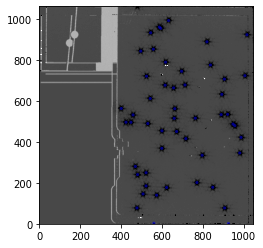

In [6]:
# Run DAOStarFinder to find sources in image

ap_radius = 4.  # radius for aperture for centroiding and photometry

daofind = DAOStarFinder(fwhm=3.0, threshold=10.*std)    # default threshold=5*std, fwhm=3
sources = daofind(data)    
print(sources['xcentroid','ycentroid','peak'])   

# Create apertures for x,y positions
positions = tuple(zip(sources['xcentroid'], sources['ycentroid']))
#print(positions)

#positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=ap_radius)

# mark sources on image frame to see if the correct sources were found
norm = ImageNormalize(stretch=SqrtStretch())
# keep image stretch in mind for plotting. sky subtracted range ~ (-15, 10), single sample ~ (0, 20)
plt.imshow(data, cmap='Greys', origin='lower', vmin=-15,vmax=10, norm=norm)
apertures.plot(color='blue', lw=1.5, alpha=0.5)
plt.show()

#### Run photometry on apertures (with a specified annulus for background subtraction)

Set a specified annulus (inner and outer radii for the annulus).

Run photometry on aperture and annuli.

Subtract background values in annulus from aperture photometry.

Output should be a table of photometry values printed to the screen (full table has columns id, xcenter, ycenter, aperture_sum and the added columns annulus_median, aperture_bkg and aperture_sum_bkgsub). You can choose which columns you wish to see printed.

In [7]:
# set values for inner and outer annuli to collect background counts

inner_annulus = 10.
outer_annulus = 15.

# set up annulus for background
background_aper = CircularAnnulus(positions, r_in=inner_annulus, r_out=outer_annulus)

# perform photometry on apertures for targets and background annuli
phot_table = aperture_photometry(im.data, apertures)

# perform background subtraction with outlier rejection
bkg_median = []
bkg_mask = background_aper.to_mask(method='center')
bmask = bkg_mask[0]
for mask in bkg_mask:
    aper_data = bmask.multiply(data)
    aper_data = aper_data[mask.data > 0]
    
    # perform sigma-clipped median
    _, median_sigclip, _ = sigma_clipped_stats(aper_data)
    bkg_median.append(median_sigclip)
bkg_median = np.array(bkg_median)


# do calculations on background regions found in annuli
# Get average background per pixel
phot_table['annulus_median'] = bkg_median
# Get total background in the science aperture (per pixel * area in aperture)
phot_table['aperture_bkg'] = bkg_median * apertures.area
# subtract background in aperture from flux in aperture
phot_table['aperture_sum_bkgsub'] = phot_table['aperture_sum'] - phot_table['aperture_bkg']

print(phot_table['aperture_sum','annulus_median','aperture_bkg','aperture_sum_bkgsub'])

2021-02-18 20:12:54,718 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



   aperture_sum    annulus_median aperture_bkg aperture_sum_bkgsub
------------------ -------------- ------------ -------------------
 4171.016739004267            0.0          0.0   4171.016739004267
3281.7104161737457            0.0          0.0  3281.7104161737457
 36256.24656252562            0.0          0.0   36256.24656252562
 36157.10650292699            0.0          0.0   36157.10650292699
 36456.20292777119            0.0          0.0   36456.20292777119
 36595.02192124154            0.0          0.0   36595.02192124154
 36462.20716072856            0.0          0.0   36462.20716072856
 36484.32693523538            0.0          0.0   36484.32693523538
 36695.91631035352            0.0          0.0   36695.91631035352
 36445.92830858928            0.0          0.0   36445.92830858928
               ...            ...          ...                 ...
 36609.17513376454            0.0          0.0   36609.17513376454
  36612.4509387485            0.0          0.0    36612.450938

#### Put x, y coordinates into RA and Dec using the wcs information from the files.
The output of the next block of code should be a table showing the x and y centroid positions as well as the associated RA and Dec values.

In [8]:
# using wcs info from images, put coordinates into RA, Dec
ra, dec = im.meta.wcs(sources['xcentroid'], sources['ycentroid'])

# add RA, Dec to sources table

ra_col = Column(name='RA', data=ra)
dec_col = Column(name='Dec', data=dec)
sources.add_column(ra_col)
sources.add_column(dec_col)

# print RA, Dec for each x, y position found
print(sources['xcentroid', 'ycentroid', 'RA', 'Dec'])   

# add option to print out list of sources with flux values
outtable = 'sourcelist_phot_rate.txt'
sources.add_column(phot_table['aperture_sum'])
sources.add_column(phot_table['aperture_sum_bkgsub'])

2021-02-18 20:12:54,770 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



    xcentroid          ycentroid      ...          Dec         
------------------ ------------------ ... ---------------------
 925.0624768761272 1.1004339705461066 ...   -0.0161008770245116
 559.9766280417598 2.3490886634672044 ... -0.017045043583186457
477.06250694578245  77.07252751580488 ... -0.014976782184965134
 906.2777302296864  76.95712671522415 ... -0.013825290704408478
 573.4127130051621  139.5245899071941 ... -0.012802415862023447
 507.0934346286894 145.57864949759187 ... -0.012795235825525343
 622.3707366677481 177.10182351151826 ... -0.011518366927105167
 848.0708494561483 178.10033577611318 ... -0.010880382317129613
 521.5540451525547 184.82626718079476 ... -0.011552798251158897
 770.5998190318766  201.4462770928865 ... -0.010372958455168075
               ...                ... ...                   ...
 695.7272087702793  745.9312957692907 ...  0.006122128066670103
 836.6505594826125  776.5382599888854 ...  0.007439915645381939
 617.4065715698218  790.4173414362584 ..

#### Compare the RA and Dec positions used to create the simulated data to the values found in the output image.
Difference each set of RA and Dec coordinates in both the input list and the found coordinates, taking into account any angles close to 360/0 degrees. If the difference for both the RA and Dec are below a set tolerance, then the positions match. Take the matched positions and convert the differences from degrees to milli arcseconds, and output the RA and Dec positions as well as the differences. 

In [9]:
# Compare input RA, Dec to found RA, Dec
print('       RA found       Dec found    RA_Diff (mas)  Dec_diff (mas)  Bkg sub flux  pass/fail')

for i in np.arange(0,len(RA_sim)):
    for j in np.arange(0,len(ra)):
        ra_diff = 180 - abs(abs(RA_sim[i] - ra[j])-180)
        dec_diff = 180 - abs(abs(Dec_sim[i] - dec[j])-180)

        if ra_diff < 1e-5 and dec_diff < 1e-5:
            # put differences in milliarcseconds
            ra_diff = ra_diff * 3600000
            dec_diff = dec_diff * 3600000
            if ra_diff < 30 and dec_diff < 30: 
                test = 'pass' 
            else: 
                test = 'fail'
            print('{:15.6f} {:15.6f} {:15.6f} {:15.6f} {:15.6f} {}'.format(ra[j], dec[j], ra_diff, dec_diff, 
                                                                        phot_table['aperture_sum_bkgsub'][j], test))

       RA found       Dec found    RA_Diff (mas)  Dec_diff (mas)  Bkg sub flux  pass/fail
     359.990963       -0.003021        3.000396        5.763891    36868.224948 pass
       0.009317       -0.000258        4.584159        8.578568    36996.434858 pass
       0.005910        0.011492        2.109129        4.018162    36363.488174 pass
     359.998084       -0.000737        2.669149        0.299491    36828.306488 pass
       0.001286        0.000412        2.612494        7.028878    36811.428802 pass
     359.997344        0.010877        0.554764        4.211479    36413.822552 pass
       0.005661       -0.014977        1.023467        0.784134    36256.246563 pass
     359.996517        0.007440        0.578772        3.296323    36612.450939 pass
     359.990957       -0.005372        0.889309        4.759317    36780.290316 pass
       0.005287        0.009061        5.579605        3.146797    36409.207028 pass
       0.001239       -0.001040        0.994439        1.637

<a id="residual_ID"></a>
# Compare output RA and Dec to expected values

The output RA and Dec coordinates should match the input RA and Dec coordinates to within 1/10 of a PSF FWHM (~0.03 arcsec for F770W).

Output RA_Diff and Dec_diff above should be on order of 30 or fewer milliarcseconds.

Check to see if your input flux is roughly what you expected based on the input data.

[Top of Page](#title_ID)

<a id="about_ID"></a>
## About this Notebook
**Author:** M. Cracraft, Research and Instrument Scientist II, INS/MIRI
<br>**Updated On:** 08/09/2019 to add in aperture photometry

An extra optional test that can be done is to plot the flux values against x or y values. Previous testing has shown a spatial dependence of the flux with y values, so a quick plot can show whether this problem is fixed or not. Prior to the resample step, there is no pattern, after the step, a pattern is clear. Just do this as a last check. If the scatter is not random, there may be a problem that needs to be checked. (Of course, this only works if you give an equivalent if not equal input count level to each input star.)

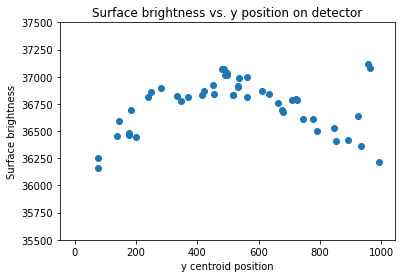

In [10]:
plt.title('Surface brightness vs. y position on detector')
plt.ylim(35500,37500) # help weed out sources that were erroneously 'hits' (bad pixels, cosmic rays, etc)
plt.xlabel('y centroid position')
plt.ylabel('Surface brightness')
plt.plot(sources['ycentroid'], phot_table['aperture_sum_bkgsub'], marker='o',linestyle='') #ylim=(30000,40000))
plt.show()

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 